In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotting
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import detrend
%matplotlib inline

In [9]:
from dataset import Dataset

In [10]:
dataset = Dataset('../data/dataset/')

In [34]:
# возьмем временной ряд авиаперевозок
ts = dataset['international-airline-passengers.csv']

In [35]:
ts, ts_test = ts[:94], ts[94:]

<Axes: xlabel='1949-01'>

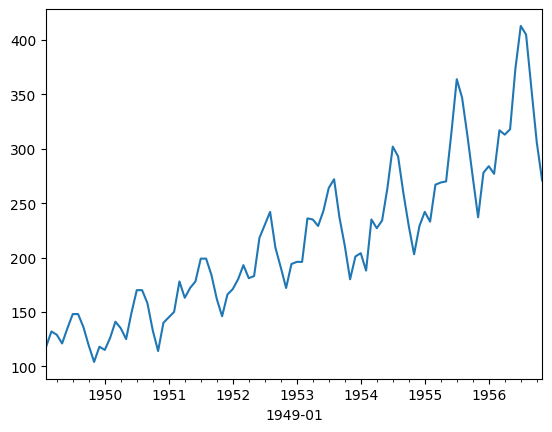

In [36]:
ts.plot()

## Box-Jenkins

In [37]:
# как можно заметить, у него есть окололинейный тренд, гетероскедастичность, сезонный период равен 12 (месяцам)

In [38]:
# сначала уберем гетероскедастичность простым логарифмированием
ts_log = np.log(ts)
plotting.plot_ts(ts_log)

Loading BokehJS ...

In [39]:
# Теперь подберем порядки дифференцирования d, D
# d малое подбирается таким образом, что d раз продифференцировав ряд, мы добьемся стационарности
# обычно таким дифференцированием убирают тренды
# D большое обычно подбирается так, что если d малое не дало стацинарности, мы можем D раз сезонно придифференцировать
# ряд, пока он не станет стационарным.

In [42]:
# для начала просто продифференцируем один раз

<Axes: xlabel='1949-01'>

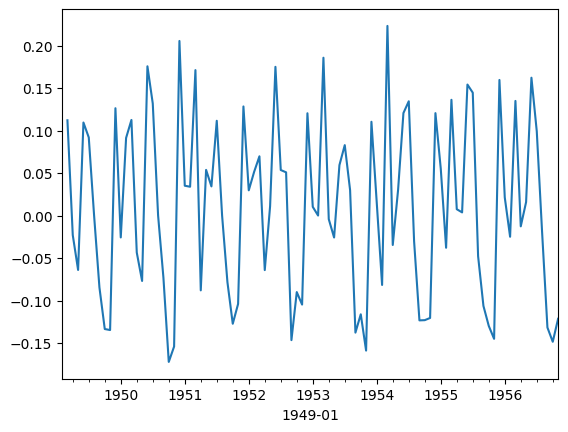

In [43]:
ts_log.diff().plot()

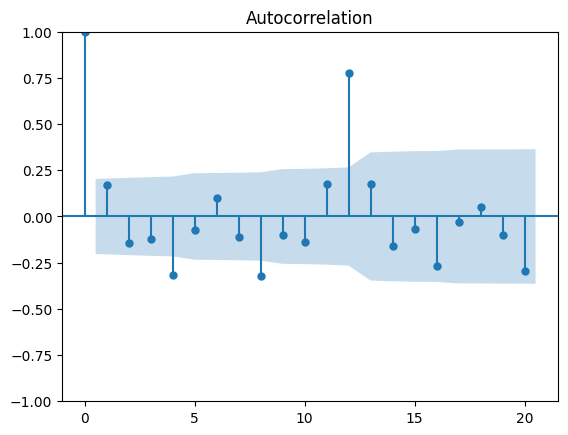

In [44]:
# в данном случае ряд сохраняет сезонность
plot_acf(ts_log.diff().dropna());

<Axes: xlabel='1949-01'>

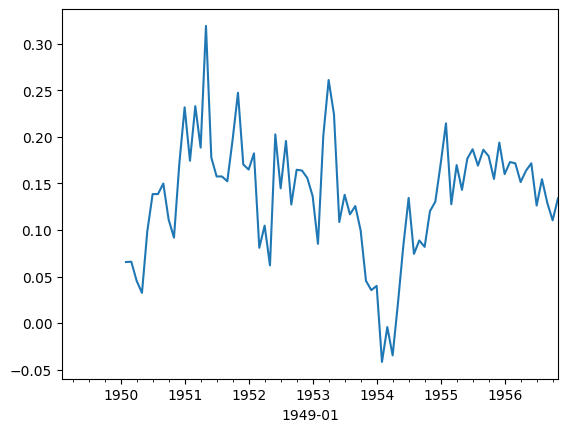

In [45]:
# попробуем применить сезонное дифференцирование 
ts_log.diff(12).plot()

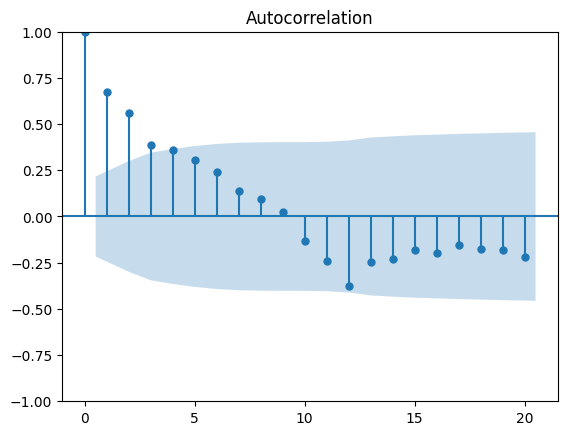

In [46]:
plot_acf(ts_log.diff(12).dropna());

In [47]:
# уже лучше
# посмотрим, что скажет критерий Дики Фуллера
# видим, что пока мы не можем отвергнуть нулевую гипотезу
adfuller(ts_log.diff(12).dropna())[1]

0.15750516812724713

<Axes: xlabel='1949-01'>

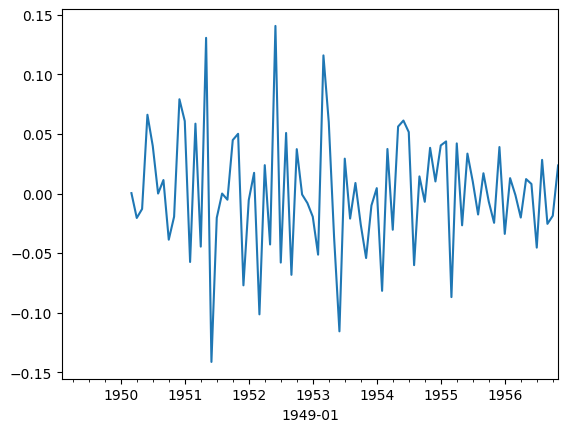

In [48]:
# давайте тогда попробуем обьединить сезонное и простое дифференцирования
ts_log.diff(12).diff().plot()

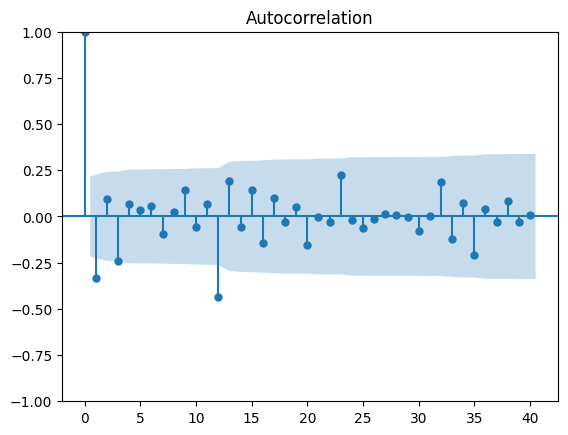

In [49]:
plot_acf(ts_log.diff(12).diff().dropna(), lags=40);

In [50]:
adfuller(ts_log.diff(12).diff().dropna())[1]

0.025934260399907906

In [51]:
# отлично, вердикт о стационарности подтвержден, (d, D) = (1, 1)

In [52]:
# теперь разберемся с параметрами q, Q, p, P.

In [53]:
ts_flat = ts_log.diff(12).diff().dropna()

<Axes: xlabel='1949-01'>

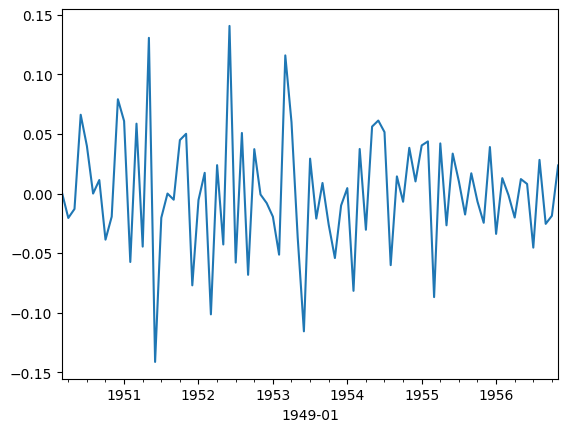

In [54]:
ts_flat.plot()

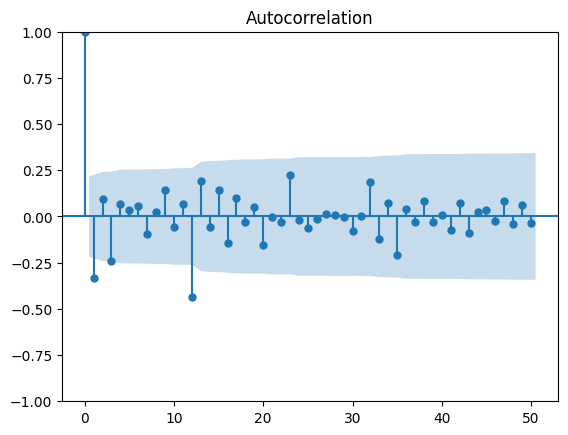

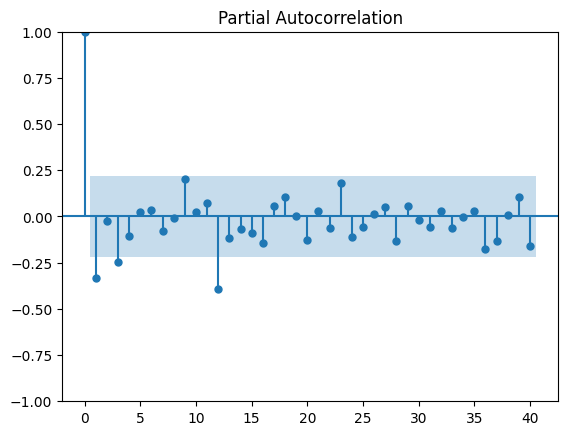

In [60]:
# отлично, для поиска параметров q, Q, p, P нарисуем график автокорреляции и частичной автокорреляции
# мы видим резкое затухание сразу на обоих графиков, поэтому подход box-jenkins не может быть здесь 
# гарантировать нахождение p, P, q, Q, возьмем из графиков примерные значения
plot_acf(ts_flat.dropna(), lags=50);
plot_pacf(ts_flat, lags=40);

In [63]:
# теперь попробуем построить SARIMA с этими параметрами

In [74]:
from statsmodels.tsa.statespace import sarimax

In [75]:
pdq = (1, 1, 1)
PDQ = (1, 1, 1, 12)

In [76]:
model = sarimax.SARIMAX(ts_log, order=pdq, seasonal_order=PDQ)

/Users/technogleb/ts_march_2024/.env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/technogleb/ts_march_2024/.env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [77]:
res = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.49305D+00    |proj g|=  4.88930D+00

At iterate    5    f= -1.51317D+00    |proj g|=  2.44046D-01

At iterate   10    f= -1.52182D+00    |proj g|=  5.65280D-01

At iterate   15    f= -1.52203D+00    |proj g|=  2.06008D-01

At iterate   20    f= -1.52569D+00    |proj g|=  1.42738D+00

At iterate   25    f= -1.53171D+00    |proj g|=  3.16657D-02

At iterate   30    f= -1.53818D+00    |proj g|=  2.62186D-02

At iterate   35    f= -1.53873D+00    |proj g|=  1.22332D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [78]:
preds = res.forecast(len(ts_test))

In [79]:
plotting.plot_ts(ts_log, preds)

Loading BokehJS ...

In [80]:
# восстановим в изначальном масштабе
plotting.plot_ts(np.exp(ts_log), ts_test, np.exp(preds))

Loading BokehJS ...

In [81]:
# Видим что получилось в целом неплохо, однако мы явно не учли остаточный тренд!

In [82]:
# чтобы убедиться еще раз, давайте проанализируем остатки

In [83]:
res = (np.exp(preds) - ts_test)

<Axes: >

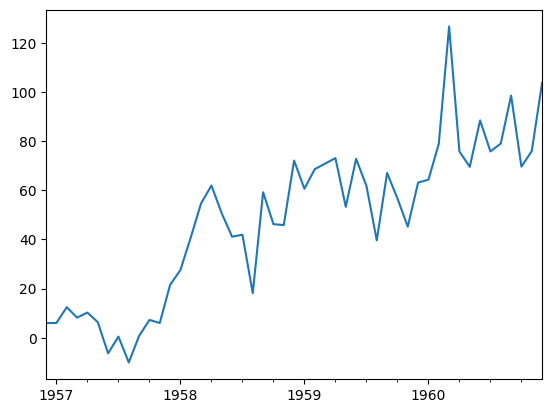

In [84]:
res.plot()

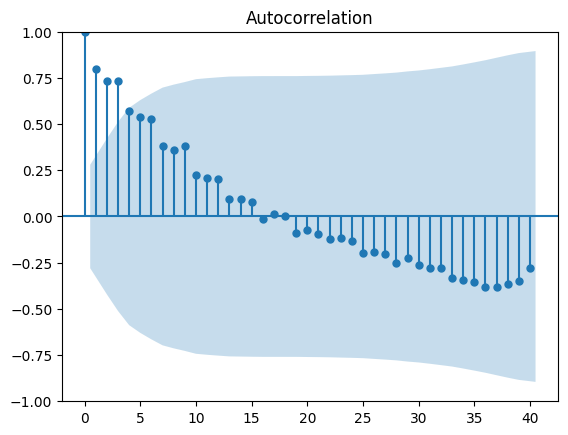

In [85]:
plot_acf(res, lags=40);

In [86]:
from sklearn.metrics import mean_squared_error as mse

mse(np.exp(preds), ts_test)

3334.3312567399603

## Auto arima

In [87]:
# наиболее удобная реализация AutoArima находится в модуле pmdarima
from pmdarima import auto_arima

In [88]:
# на вход подается ряд со всеми преобразованиями кроме дифференцирования, границы поиска параметров p, q, P, Q, 
# периодом сезонности m, параметрами дифференцирования d, D
model = auto_arima(
     ts_log, start_p=0, start_q=0,
     max_p=3, max_q=3, m=12,
     start_P=0, start_Q=0, seasonal=True,
     d=1, D=1, trace=True,
     error_action='ignore',
     suppress_warnings=True,
     stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-251.288, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-276.012, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-282.411, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-259.897, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-280.475, Time=0.25 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-280.470, Time=0.46 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-277.759, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-278.576, Time=1.26 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-274.387, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-281.256, Time=0.28 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-280.798, Time=0.30 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-281.134, Time=0.10 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-278.423, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-280.477, Time=0.37 sec

Best model:  ARIMA

In [89]:
# в результате работы возвращается обьект ARIMA
model

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [90]:
# прогноз можем получить методом predict, указав горизонт прогнозирования
preds = model.predict(len(ts_test))

In [91]:
plotting.plot_ts(np.exp(ts_log), ts_test, pd.Series(np.exp(preds), index=ts_test.index))

Loading BokehJS ...